# Antutu benchmark on Android

The goal of this experiment is to run benchmarks on a hikey960 board running Android with an IPA kernel and collect results. The analysis phase will consist in comparing IPA summary with:
    
The benchmark we will be using is ***Antutu 3Dbench*** (http://www.antutu.com/en). You will need to **manually install** the app on the Android device in order to run this Notebook.

the goals of this notebook:
1. analyse the thermal zone temperature
1. analyse the CPU’s busy load based on current frequency,  and the normalized busy load based on the max frequency.
1. analyse PID algorithm, the SOC’s guaranteed power in one time, and check CPU/GPU requested power and allocated power. 


In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2018-05-08 11:45:27,737 INFO    : root         : Using LISA logging configuration:
2018-05-08 11:45:27,739 INFO    : root         :   /home/steven/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import copy
import os
from time import sleep
from subprocess import Popen
import pandas as pd

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in `my_target_conf`. Run `adb devices` on your host to get the ID. Also, you have to specify the path to your android sdk in ANDROID_HOME.

In [3]:
# Setup a target configuration
my_target_conf = {
    
#     # Target platform and board
#     "platform"    : 'android',

#     # Add target support
#     "board" : 'pixel',
    
#     # Device ID
#     "device" : "HT6670300102",
    
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/steven/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "thermal_power_devfreq_limit",
            "thermal_power_devfreq_get_power",
            "thermal_power_cpu_limit",
            "thermal_power_cpu_get_power",
            "thermal_zone_trip",
            "cdev_update",
            "thermal_temperature",
            "thermal_power_allocator_pid",
            "thermal_power_allocator",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
    
    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],
}

In [4]:
my_tests_conf = {

    # Folder where all the results will be collected
    "results_dir" : "Android_antutu_angrybird",

    # Platform configurations to test
    "confs" : [
        {
            "tag"            : "antutu",
            "flags"          : "ftrace",           # Enable FTrace events
            "sched_features" : "ENERGY_AWARE",     # enable EAS
        },
    ],
}

In [5]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2018-05-08 11:45:31,394 INFO    : TestEnv      : Using base path: /home/steven/lisa/lisa-github
2018-05-08 11:45:31,397 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-05-08 11:45:31,399 INFO    : TestEnv      : Loading custom (inline) test configuration
2018-05-08 11:45:31,405 INFO    : TestEnv      : External tools using:
2018-05-08 11:45:31,407 INFO    : TestEnv      :    ANDROID_HOME: /home/steven/lisa/android-sdk
2018-05-08 11:45:31,408 INFO    : TestEnv      :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
2018-05-08 11:45:31,409 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2018-05-08 11:45:31,411 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2018-05-08 11:45:31,412 INFO    : TestEnv      : Connection settings:
2018-05-08 11:45:31,413 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2018-05-08 11:45:33,288 INFO    : TestEnv      : Initializing target workdir:
2018-05-08 1

## Support Functions

This set of support functions will help us running the benchmark using different CPUFreq governors.

In [6]:
#Check if PCMark si available on the device

def check_packages(pkgname):
    try:
        output = target.execute('pm list packages -f | grep -i {}'.format(pkgname))
    except Exception:
        raise RuntimeError('Package: [{}] not availabe on target'.format(pkgname))

# Check for specified PKG name being available on target
check_packages('com.antutu.ABenchMark')
check_packages('com.rovio.angrybirds')
target.adb_root(force=True)

In [7]:
from android import Screen

target.execute('am force-stop {}'.format("com.antutu.ABenchMark"))
target.execute('input keyevent 4')
Screen.set_orientation(target, auto=False, portrait=True)
Screen.set_brightness(target, auto=False, percent=0)
target.cpufreq.set_all_governors('schedutil')

# Start PCMark on the target devicex
#target.execute('monkey --pct-syskeys 0 -p com.antutu.ABenchMark -c android.intent.category.LAUNCHER 1')
# Wait few seconds to make sure the app is loaded
# Screen.set_orientation(target, auto=False, portrait=True)
#sleep(10)
#target.execute('input tap 961 202')
# Wait few seconds to make sure the app is loaded
# sleep(5)
    

# Run performance workload (assume screen is vertical)


2018-05-08 11:45:38,393 INFO    : Screen       : Force manual orientation
2018-05-08 11:45:38,398 INFO    : Screen       : Set orientation: PORTRAIT
2018-05-08 11:45:39,732 INFO    : Screen       : Set brightness: 0%


''

In [8]:
# Function that helps run a Antutu experiment
from android import Screen
from devlib.utils.android import adb_command

def benchmark_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('am force-stop {}'.format("com.antutu.ABenchMark"))
    target.execute('input keyevent 82')
    Screen.set_brightness(target, auto=False, percent=0)

    # Start PCMark on the target device
    target.execute('monkey --pct-syskeys 0 -p com.antutu.ABenchMark  1')
#     Screen.set_orientation(target, auto=False, portrait=True)

    # Wait few seconds to make sure the app is loaded
    sleep(5)
    
    # Flush entire log
    target.clear_logcat()
    target.execute('input tap 860 1000')
    sleep(1)
    Screen.set_orientation(target, auto=False, portrait=True)
    # Run performance workload (assume screen is vertical)
    target.execute('input tap 960 200')
    # Wait for completion (10 minutes in total) and collect log
#     log_file = os.path.join(exp_dir, 'log.txt')
    # Wait 5 minutes
    sleep(30)
    # Start collecting the log
#     with open(log_file, 'w') as log:
#         logcat = Popen(['adb logcat', 'com.antutu.ABenchMark.VirtualMachineState:*', '*:S'],
#                        stdout=log,
#                        shell=True)
#         # Wait additional two minutes for benchmark to complete
#         sleep(300)

#         # Terminate logcat
#         logcat.kill()

#     # Get scores from logcat
#     score_file = os.path.join(exp_dir, 'score.txt')
#     os.popen('grep -o ".*_SCORE .*" {} | sed "s/ = / /g" | sort -u > {}'.format(log_file, score_file))
    
    # Close application
    adb_command(target.adb_name, 'shell screencap -p /data/local/tmp/screen.png')
    adb_command(target.adb_name, 'pull /data/local/tmp/screen.png {}'.format(te.res_dir))
    target.execute('am force-stop com.antutu.ABenchMark')
    target.execute('am force-stop com.antutu.benchmark.full')

  

In [9]:
def angrybird_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('am force-stop {}'.format("com.rovio.angrybirds"))
    Screen.set_brightness(target, auto=False, percent=0)

    # Start PCMark on the target device
    target.execute('am start com.rovio.angrybirds/com.rovio.fusion.App')
    Screen.set_orientation(target, auto=False, portrait=True)

#     Screen.set_orientation(target, auto=False, portrait=True)

    # Wait few seconds to make sure the app is loaded
    sleep(15)
    
    # Flush entire log
    target.clear_logcat()
    target.execute('input tap 1826 994')
    target.execute('input tap 150 694')
    target.execute('input tap 174 182')

    sleep(8)

    target.execute('input swipe 651 483 478 539')
    # Run performance workload (assume screen is vertical)
    sleep(8)

    target.execute('input tap 968 865')
    # Wait for completion (10 minutes in total) and collect log
#     log_file = os.path.join(exp_dir, 'log.txt')
    # Wait 5 minutes
    target.execute('input swipe 651 483 478 539')
    # Start collecting the log
#     with open(log_file, 'w') as log:
#         logcat = Popen(['adb logcat', 'com.antutu.ABenchMark.VirtualMachineState:*', '*:S'],
#                        stdout=log,
#                        shell=True)
#         # Wait additional two minutes for benchmark to complete
#         sleep(300)

#         # Terminate logcat
#         logcat.kill()

#     # Get scores from logcat
#     score_file = os.path.join(exp_dir, 'score.txt')
#     os.popen('grep -o ".*_SCORE .*" {} | sed "s/ = / /g" | sort -u > {}'.format(log_file, score_file))
    
    # Close application

    target.execute('am force-stop {}'.format("com.rovio.angrybirds"))



In [10]:
# Function that helps run PCMark for different governors

def experiment(func, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));
    trace_file = os.path.join(exp_dir, 'trace.dat')

    logging.info('------------------------')
    logging.info('Run workload using %s', func)

    ### Run the benchmark ###
    te.ftrace.start()

    func(exp_dir)
    
    te.ftrace.stop()
    te.ftrace.get_trace(trace_file)

    # return all the experiment data
    return {
        'dir'        : exp_dir,
    }

## Run Antutu and collect scores

In [11]:
# Run the benchmark in all the configured governors
testresult_list=[]

test_dir = os.path.join(te.res_dir, "angrybirds")
res = experiment(angrybird_run, test_dir)
testresult_list.append(test_dir)
print test_dir

test_dir = os.path.join(te.res_dir, "antutu")
res = experiment(benchmark_run, test_dir)
testresult_list.append(test_dir)
print test_dir

2018-05-08 11:45:45,413 INFO    : root         : ------------------------
2018-05-08 11:45:45,415 INFO    : root         : Run workload using <function angrybird_run at 0x7f209b6e79b0>
2018-05-08 11:45:49,001 INFO    : Screen       : Set brightness: 0%
2018-05-08 11:45:49,319 INFO    : Screen       : Force manual orientation
2018-05-08 11:45:49,320 INFO    : Screen       : Set orientation: PORTRAIT
2018-05-08 11:46:26,171 INFO    : root         : ------------------------
2018-05-08 11:46:26,173 INFO    : root         : Run workload using <function benchmark_run at 0x7f209b5fcd70>


/home/steven/lisa/lisa-github/results/20180508_114531/angrybirds


2018-05-08 11:46:30,189 INFO    : Screen       : Set brightness: 0%
2018-05-08 11:46:37,114 INFO    : Screen       : Force manual orientation
2018-05-08 11:46:37,116 INFO    : Screen       : Set orientation: PORTRAIT


/home/steven/lisa/lisa-github/results/20180508_114531/antutu


After running the benchmark for the specified governors we can show and plot the scores:

In [15]:
map_label = {"00000000,000000f0": "big", "00000000,0000000f": "LITTLE"}
actor_order = ["GPU", "big", "LITTLE"]


In [12]:
!tree {te.res_dir}

/home/steven/lisa/lisa-github/results/20180508_114531
├── angrybirds
│   └── trace.dat
├── antutu
│   └── trace.dat
└── screen.png

2 directories, 3 files


In [13]:
testresult_list[0]

'/home/steven/lisa/lisa-github/results/20180508_114531/angrybirds'

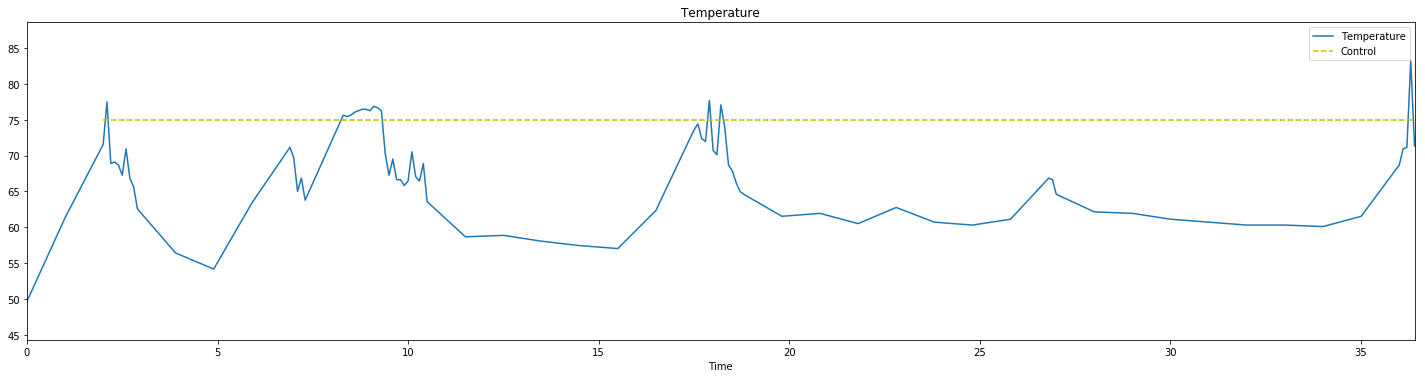

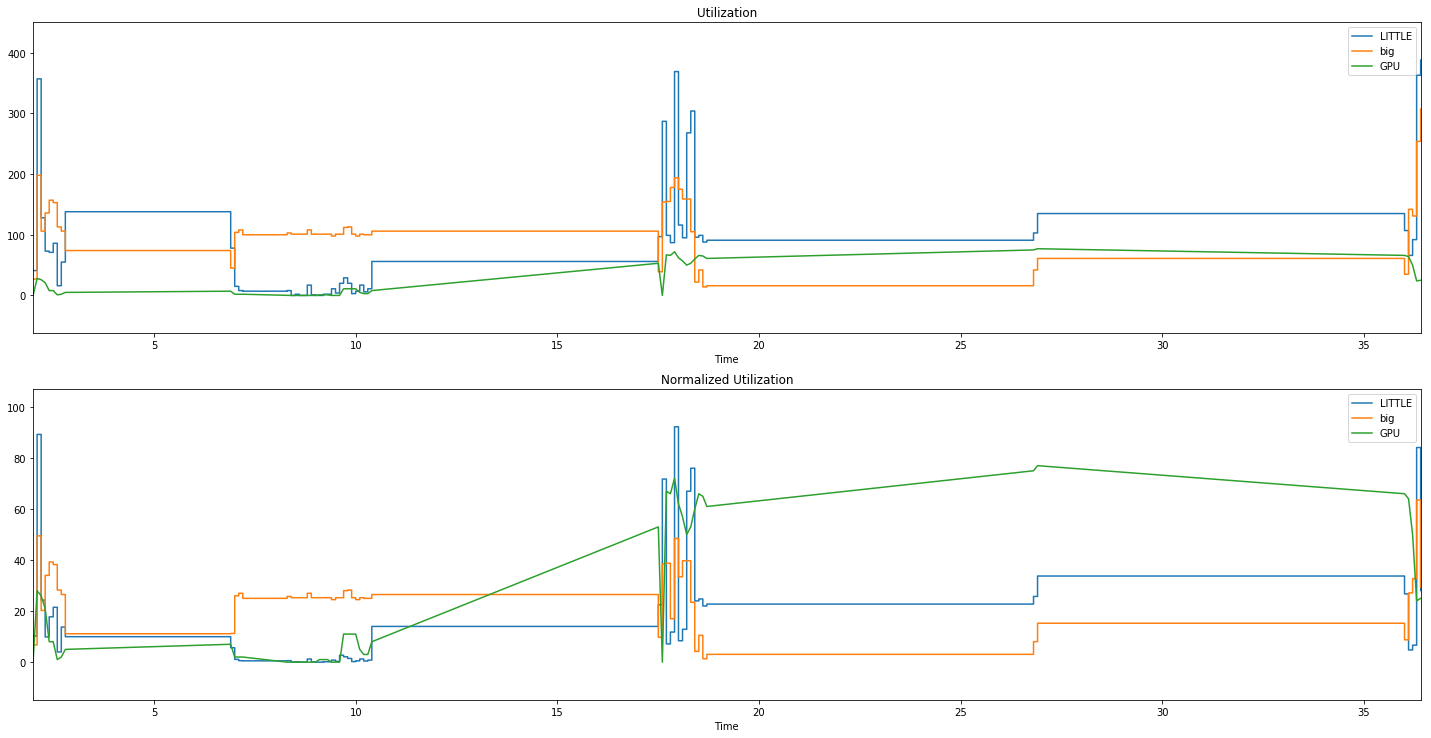

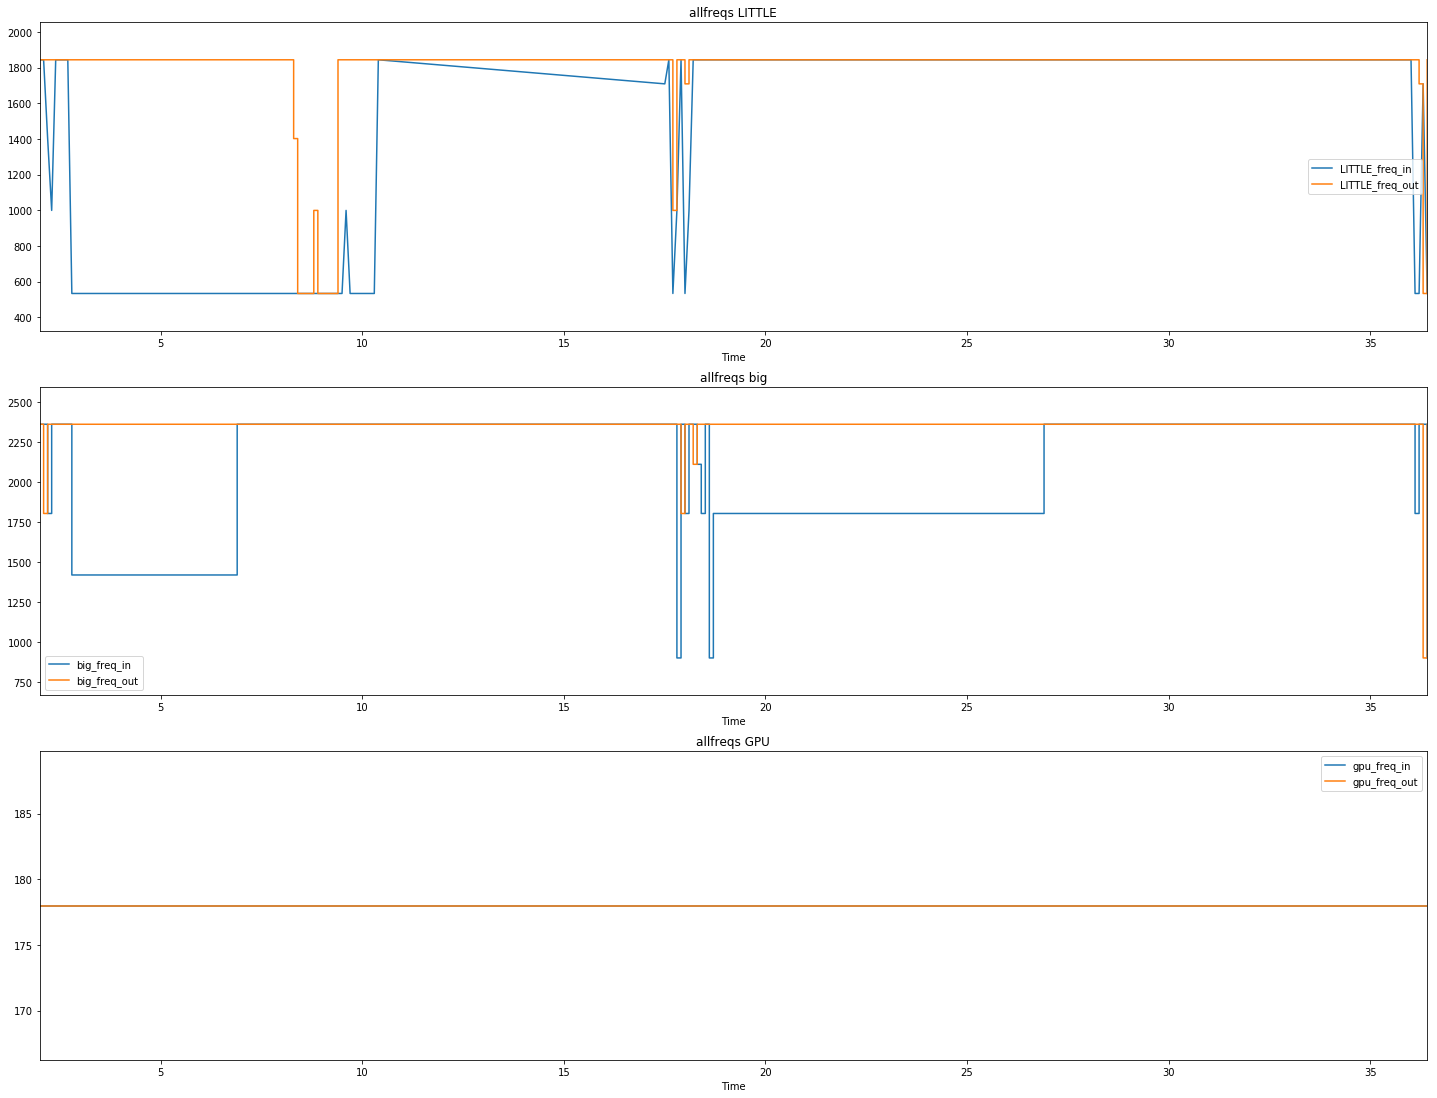

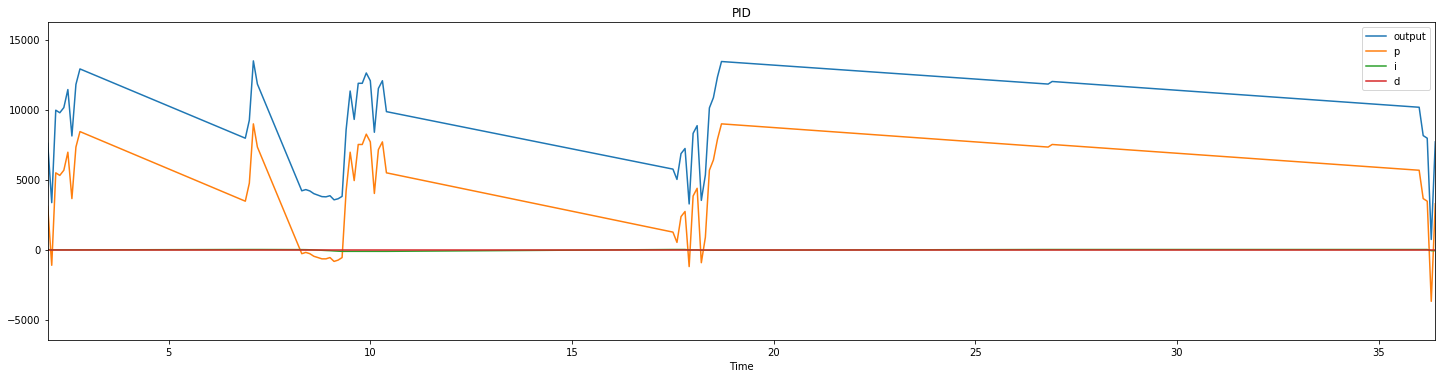

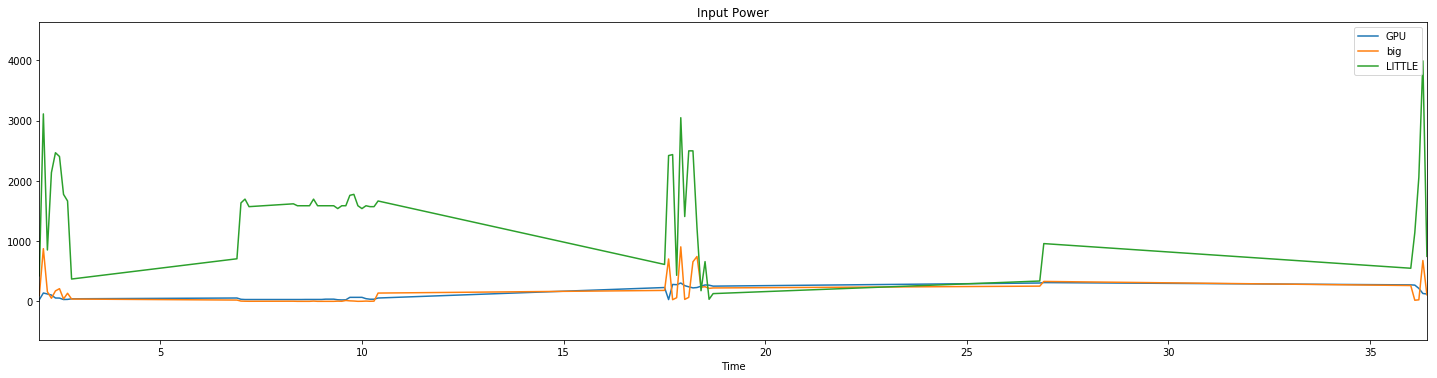

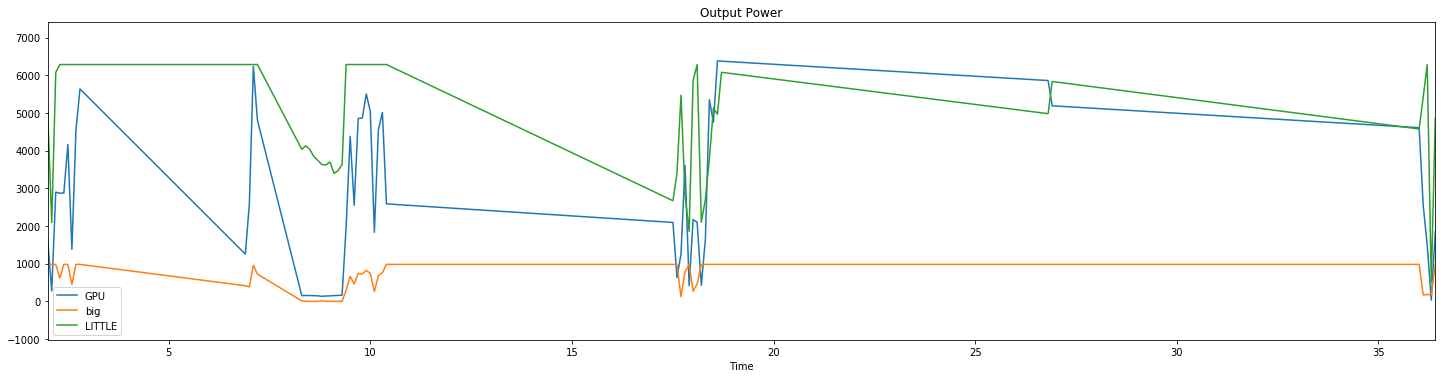

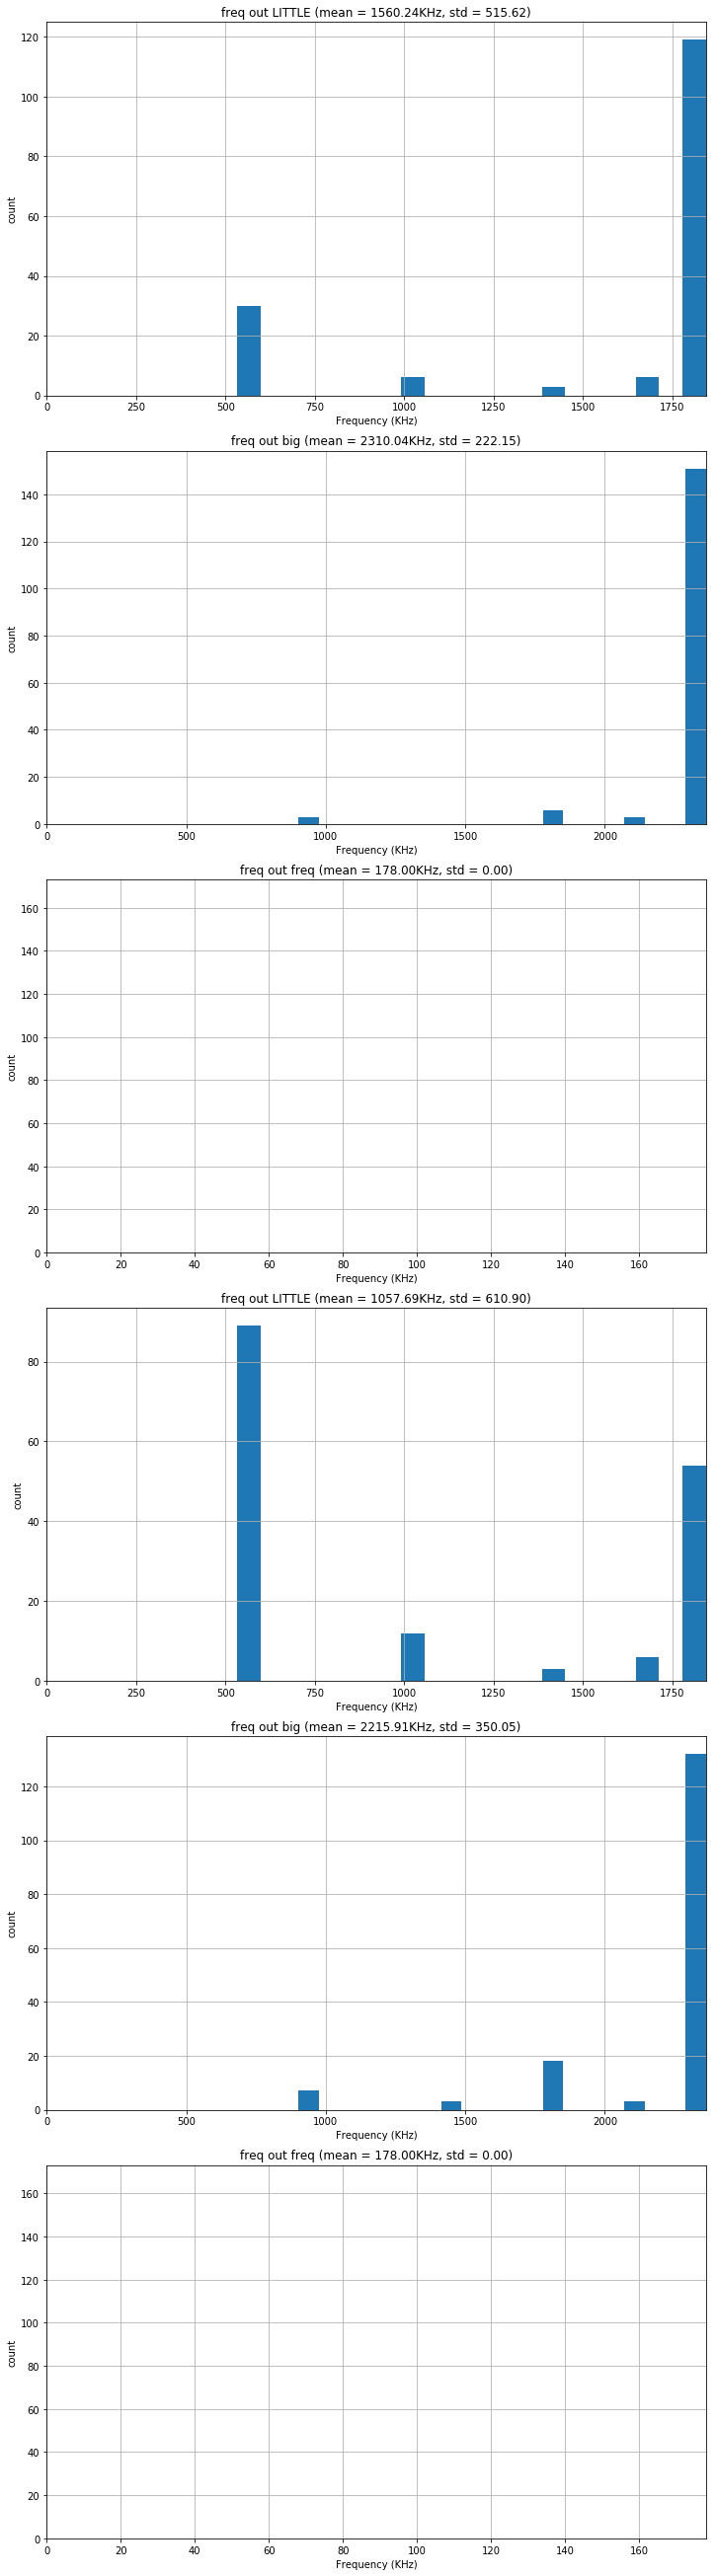

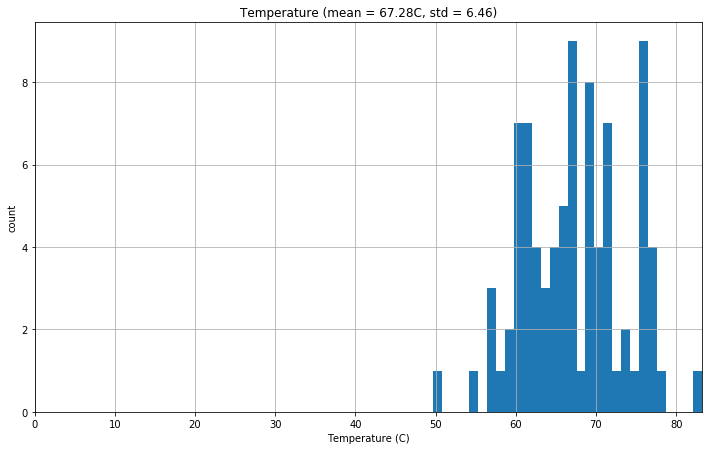

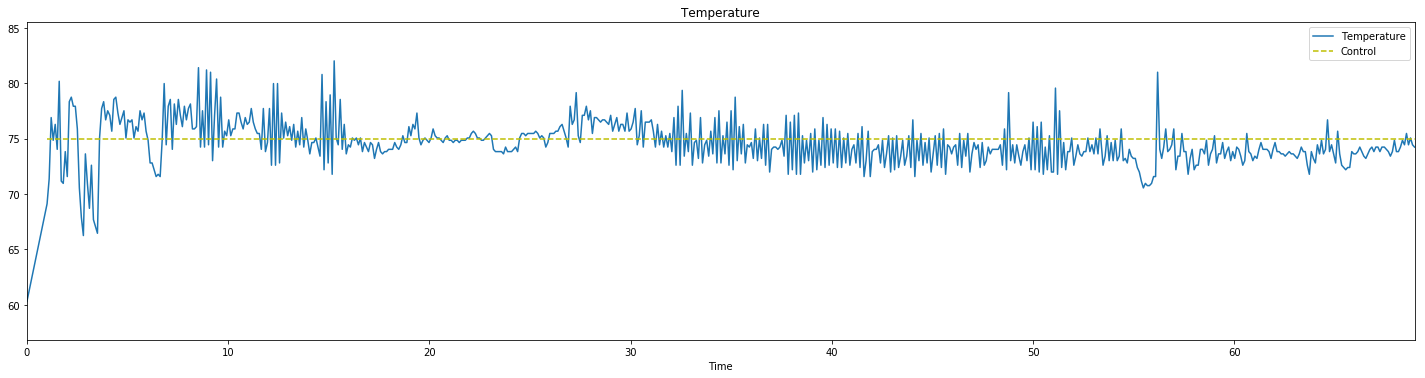

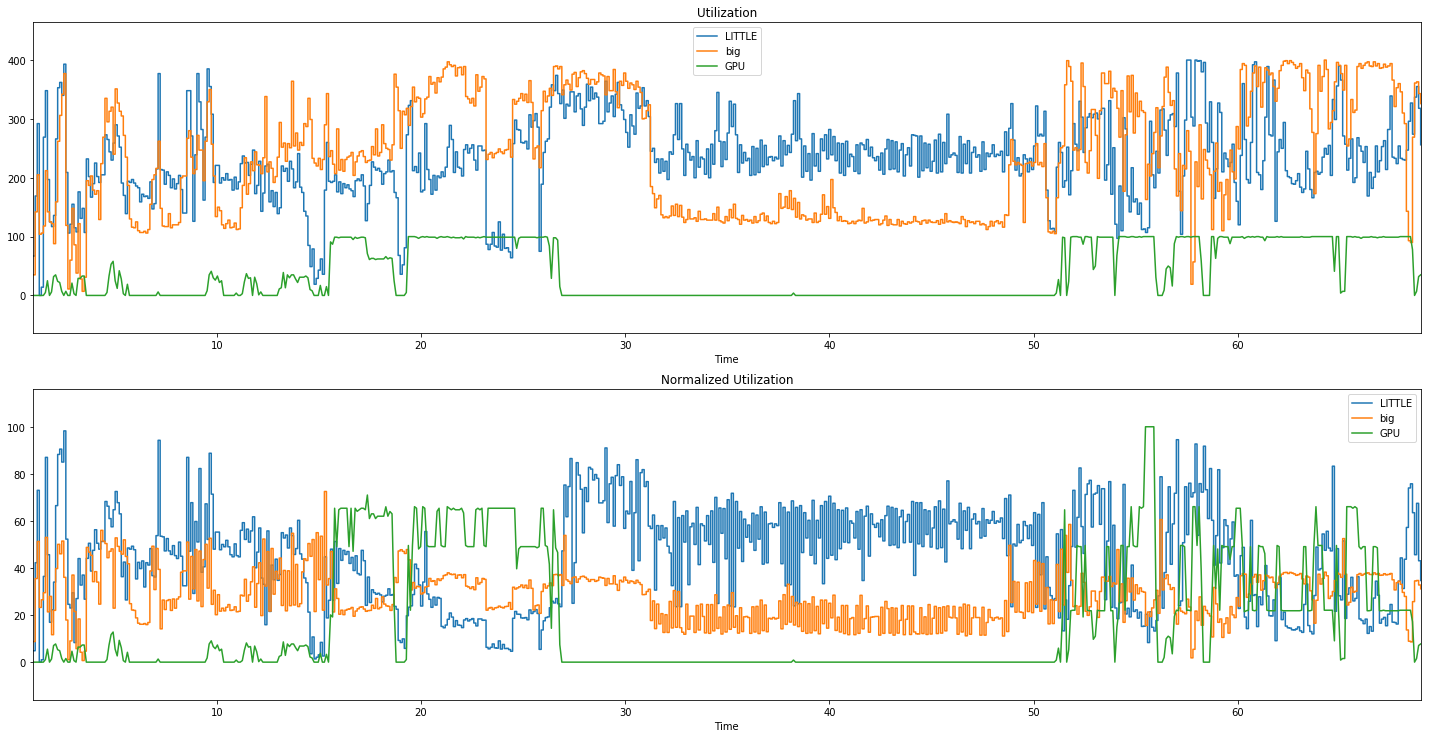

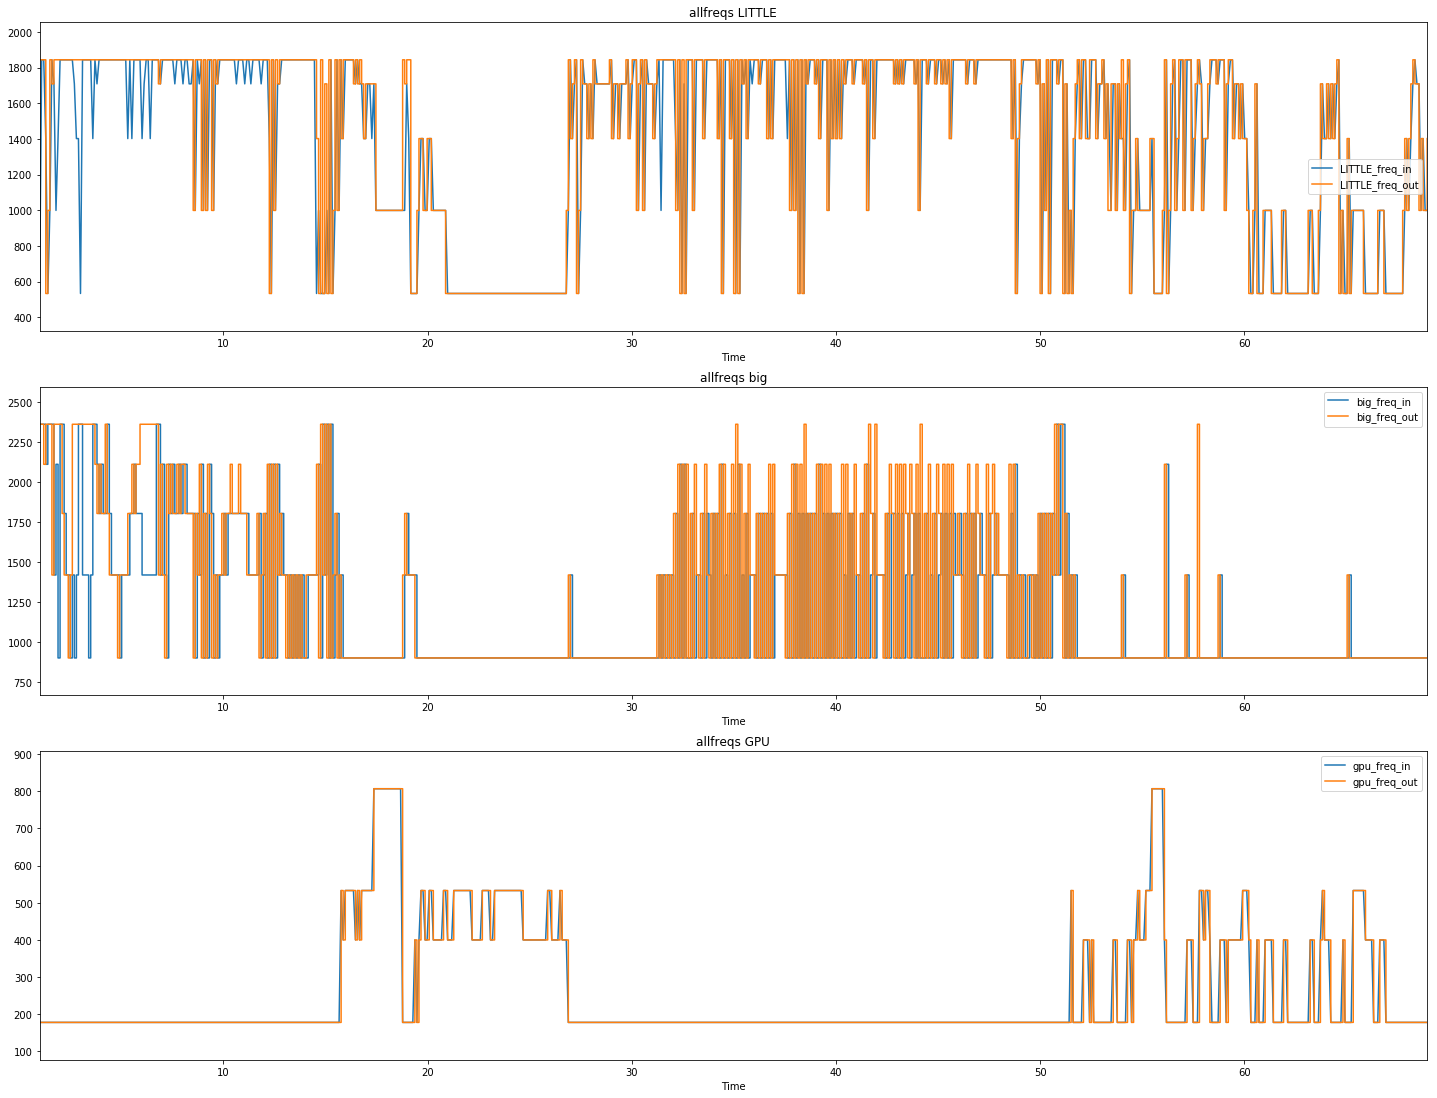

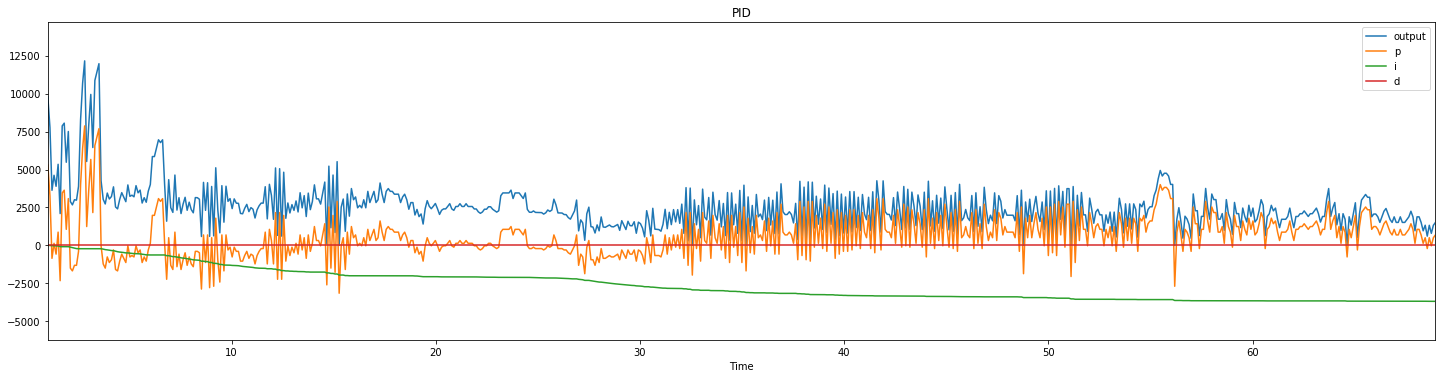

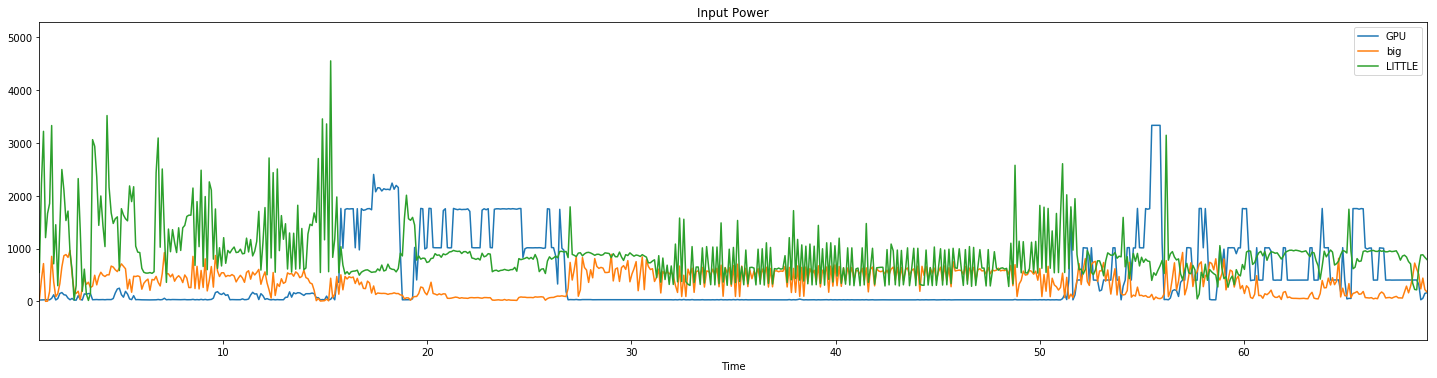

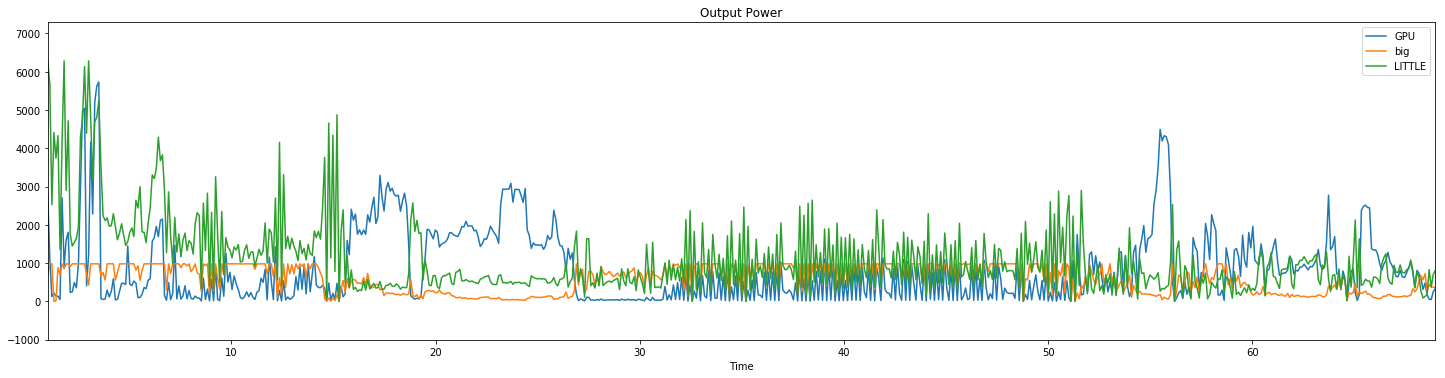

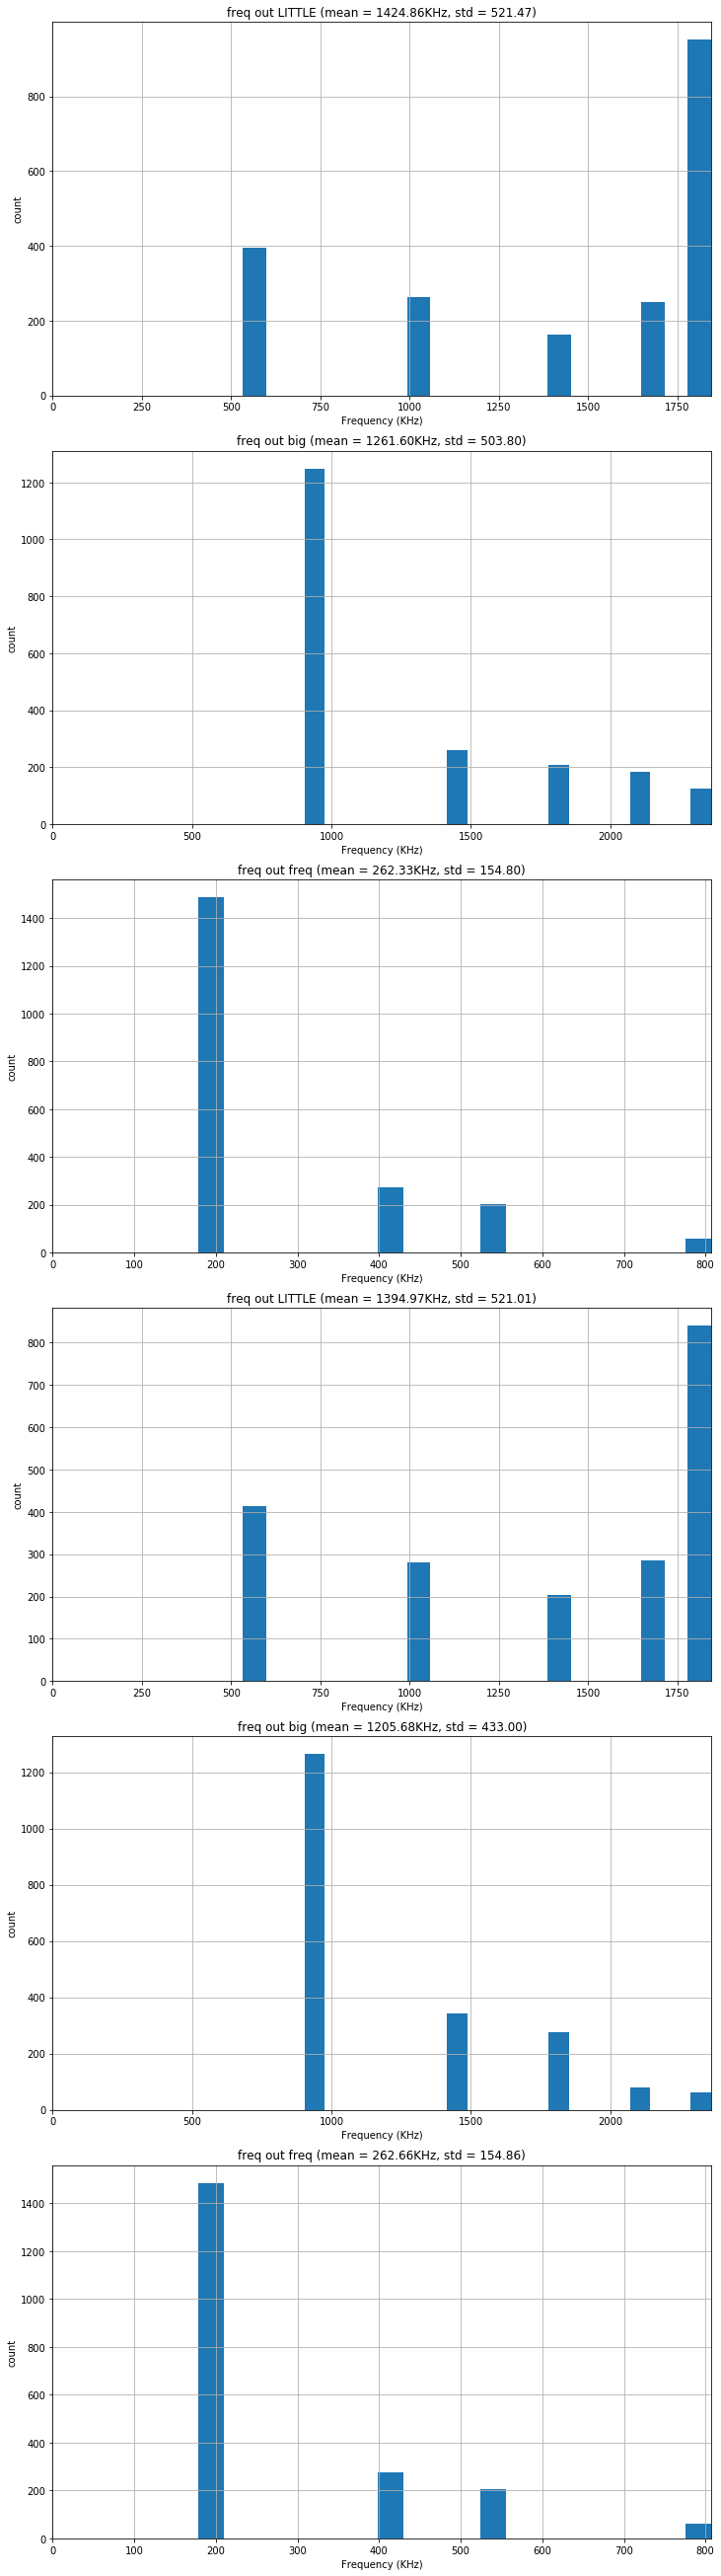

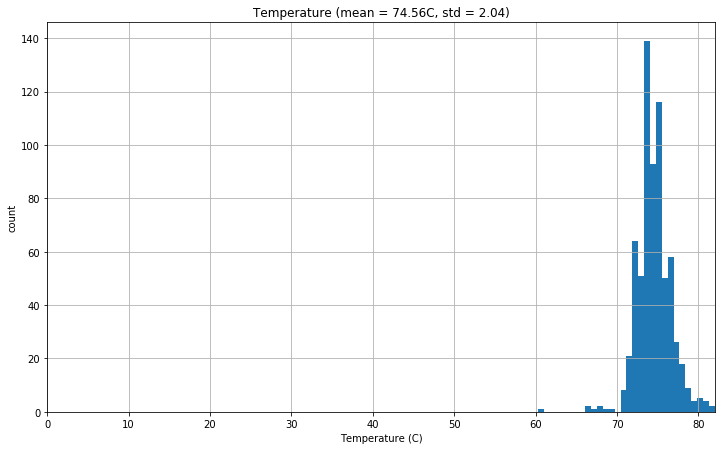

In [17]:
for res in testresult_list:
    trappy.summary_plots(actor_order, map_label, path=os.path.join(res, 'trace.dat'))

In [33]:
target.execute('am force-stop com.antutu.ABenchMark')
target.execute('am force-stop com.antutu.benchmark.full')

''